In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
from gpzoo.kernels import MGGP_RBF
from gpzoo.gp import MGGP_SVGP
from gpzoo.likelihoods import GaussianLikelihood

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(32)

noise_variance = torch.tensor(0.05)
n0, n1 = 100, 100


X0 = distributions.Uniform(-10, 10).sample(sample_shape=(n0,1))
X1 = distributions.Uniform(-10, 10).sample(sample_shape=(n1,1))

X = torch.concatenate([X0, X1], axis=0)
X_groups = torch.concatenate([torch.zeros(n0), torch.ones(n1)]).type(torch.LongTensor)

In [3]:
kernel_true = MGGP_RBF(sigma=1.0, lengthscale=1.0, group_diff_param=1.0)
kernel_true.input_dim = 1
cov = kernel_true.forward(X, X, X_groups, X_groups)+ noise_variance.expand(n0+n1).diag()
Y = distributions.MultivariateNormal(torch.zeros(len(X)), cov).sample()

In [4]:
class ExactGP(torch.nn.Module):
    def __init__(self, kernel):
        super().__init__()
        self.kernel = kernel
        self.noise = torch.nn.Parameter(torch.tensor(0.1))
        
    def forward(self, X, groupsX):
        N = len(X)
        Kxx = kernel.forward(X, X, groupsX, groupsX)
        pY = torch.distributions.MultivariateNormal(torch.zeros(N), Kxx + (self.noise**2)*torch.eye(N))
        return pY
    
    def predict(self, X, groupsX, Z, groupsZ, y):
        Kxx = kernel.forward(X, X, groupsX, groupsX)
        Kxz = kernel.forward(X, Z, groupsX, groupsZ)
        Kzz = kernel.forward(Z, Z, groupsZ, groupsZ)
        
        W = (Kxz.T)@torch.inverse(Kxx)
        
        mean = torch.squeeze(W@y)
        cov = Kzz - W@(Kxz)
        N = len(Z)
        cov[::N+1]+= 1e-1
        pY = torch.distributions.MultivariateNormal(mean, cov)
        

In [5]:
kernel = MGGP_RBF(sigma=1.0, lengthscale=3.0, group_diff_param=0.001)
model = ExactGP(kernel)

In [6]:
def train(model, optimizer, X, groupsX, y, steps=200, E=20):
    losses = []
    for it in tqdm(range(steps)):
        optimizer.zero_grad()
        
        pY = model.forward(X, groupsX)
        loss = -pY.log_prob(y)
        loss = loss.sum()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    return losses

In [7]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [8]:
losses = train(model, optimizer, X, X_groups, Y, steps=10000, E=100)

  0%|          | 0/10000 [00:00<?, ?it/s]

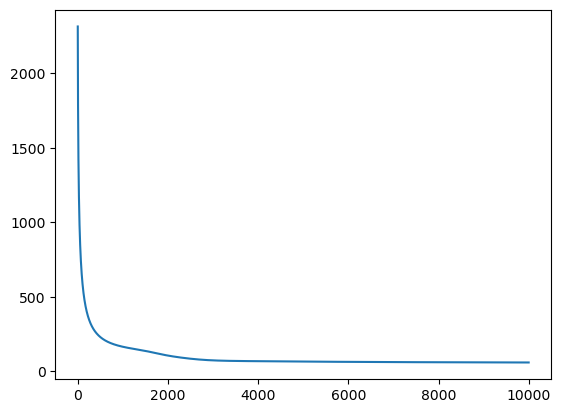

In [9]:
plt.plot(losses)

In [10]:
kernel.group_diff_param

Parameter containing:
tensor(0.6252, requires_grad=True)

In [11]:
ntest = 500
Xtest_onegroup = torch.linspace(-10, 10, ntest)[:, None]
Xtest = torch.concatenate([Xtest_onegroup, Xtest_onegroup], axis=0)
Xtest_groups = torch.concatenate([torch.zeros(ntest), torch.ones(ntest)]).type(torch.LongTensor)
pY = model.predict(X, X_groups, Xtest, Xtest_groups, Y)
mean = pY.mean.detach()

ValueError: Expected parameter covariance_matrix (Tensor of shape (1000, 1000)) of distribution MultivariateNormal(loc: torch.Size([1000]), covariance_matrix: torch.Size([1000, 1000])) to satisfy the constraint PositiveDefinite(), but found invalid values:
tensor([[ 0.0882,  0.0904,  0.0929,  ...,  0.0372,  0.0392,  0.0413],
        [-0.0347, -0.0347, -0.0346,  ..., -0.0530, -0.0512, -0.0493],
        [-0.2021, -0.2070, -0.2118,  ..., -0.0019, -0.0019, -0.0019],
        ...,
        [ 0.0066,  0.0063,  0.0059,  ...,  0.0076,  0.0077,  0.0077],
        [ 0.0137,  0.0137,  0.0137,  ...,  0.0342,  0.0330,  0.0318],
        [ 0.0108,  0.0106,  0.0104,  ...,  0.0679,  0.0662,  0.0644]],
       grad_fn=<ExpandBackward0>)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(X[:n0], Y[:n0], color="red", label="Data, group 1")
ax.scatter(X[n0:], Y[n0:], color="blue", label="Data, group 2")
ax.plot(Xtest[:ntest], mean[:ntest], color="red", label="Predictions, group 1")
ax.plot(
    Xtest[ntest:], mean[ntest:], color="blue", label="Predictions, group 2"
)
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.tight_layout()

In [13]:
model.kernel.lengthscale

Parameter containing:
tensor(0.8931, requires_grad=True)

In [14]:
model.kernel.sigma

Parameter containing:
tensor(0.8272, requires_grad=True)

In [78]:
(pY.scale.squeeze()[0])**2.0

tensor(0.0887, grad_fn=<PowBackward0>)

In [79]:
model.gp.kernel.group_diff_param

Parameter containing:
tensor(1.8127, requires_grad=True)

In [81]:
torch.nn.functional.softplus(model.noise)

tensor(0.2979, grad_fn=<SoftplusBackward0>)